In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix
import numpy as np

color = '#4682B4'
df = pd.read_parquet('../data/manual_predictions.parquet')
comments_df =pd.read_parquet('../data/comments_sample.parquet')

df = df[['id', 'rating']]\
    .merge(
    comments_df[['id', 'rating', 'language']]
    .rename(columns={'rating':'real_rating'}),
    on='id',
    how='inner'
    ).drop(columns='id')\
    .rename(columns={'rating':'manual_prediction'})


df[f'is_inconsistent_manual'] = (
    (df[f'manual_prediction'] - df['real_rating']).abs() > 1
    ).astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   manual_prediction       1000 non-null   int64 
 1   real_rating             1000 non-null   int64 
 2   language                1000 non-null   object
 3   is_inconsistent_manual  1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


In [57]:
def plot_rating_distribution(
    df,
    mode='overall',                # 'overall', 'langs' ou 'all'
    rating_col='rating',
    lang_col='language',
    langs=('pt', 'en'),
    color='steelblue',
    figsize=(6, 4),
    title_fmt=None,                # ex: 'Distribuição de Notas ({label})'
    xlabel='Nota',
    ylabel='Frequência',
    show_title=True                # Novo parâmetro para controlar a exibição do título
):
    """
    Plota distribuição de ratings em até 3 gráficos lado a lado:
      - overall: apenas o gráfico total
      - langs:   apenas os gráficos de cada idioma (pt e en)
      - all:     total + pt + en

    Parâmetros:
    - df: pandas.DataFrame com colunas rating_col e lang_col
    - mode: 'overall', 'langs' ou 'all'
    - rating_col: nome da coluna de nota
    - lang_col: nome da coluna de linguagem
    - langs: tupla com os códigos de idioma
    - color: cor das barras
    - figsize: tamanho da figura base para um plot (width, height)
    - title_fmt: formato de título, deve conter '{label}' ou None para títulos fixos
    - xlabel, ylabel: rótulos dos eixos
    - show_title: bool, se True, exibe o título do(s) gráfico(s)
    """
    # Prepara subsets e labels
    subsets = []
    if mode in ('overall', 'all'):
        subsets.append(('Total', df))
    if mode in ('langs', 'all'):
        for lang in langs:
            subsets.append((str(lang).upper(), df[df[lang_col] == lang]))

    n = len(subsets)
    if n == 0:
        raise ValueError("mode deve ser 'overall', 'langs' ou 'all'")

    # Ajusta o layout dos subplots
    fig, axes = plt.subplots(ncols=n,
                             figsize=(figsize[0] * n, figsize[1]),
                             sharey=False,
                             dpi=120)
    if n == 1:
        axes = [axes]

    # Prepara os títulos apenas se show_title for True
    titles = {}
    if show_title:
        if title_fmt is None:
            # Títulos default se não informados
            titles = {
                'Total': 'Distribuição Total',
                str(langs[0]).upper(): f'Distribuição ({str(langs[0]).upper()})',
                str(langs[1]).upper(): f'Distribuição ({str(langs[1]).upper()})'
            }
        elif isinstance(title_fmt, str):
            # Formato de título único para todos
            titles = {label: title_fmt.format(label=label) for label, _ in subsets}
        else:
            # Dicionário de títulos já fornecido
            titles = title_fmt

    for ax, (label, subdf) in zip(axes, subsets):
        counts = subdf[rating_col].value_counts().sort_index()
        total = counts.sum()

        # Desenha as barras
        counts.plot(kind='bar', color=color, ax=ax)

        # Adiciona o título se show_title for True
        if show_title:
            txt = titles.get(label, '')  # Obtém o título para o label atual
            ax.set_title(txt, fontsize=14, fontweight='bold')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        # Ajusta o eixo y para dar espaço às anotações
        ax.set_ylim(0, counts.max() * 1.15 if total > 0 else 1)

        # Anotações de contagem e percentual
        for i, count in enumerate(counts):
            pct = (count / total * 100) if total > 0 else 0
            ax.text(i, count, f'{count:,}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=8)
        
        ax.set_xticklabels(counts.index.astype(str), rotation=0)

    plt.tight_layout()
    plt.show()
    return fig, axes

def plot_confusion_matrix(
    df,
    mode='overall',                # 'overall', 'langs', or 'all'
    real_col='real_rating',
    pred_col='manual_prediction',
    lang_col='language',
    labels=None,
    cmap=plt.cm.Blues,
    figsize=(8, 6),
    titles=('Todos', 'PT', 'EN'),
    border_cells=(1,2,6,7,8,12,13,14,18,19,20,24,25),
    border_kwargs=None,
    invert_highlight=False,
    show_title=True,
    xlabel='Predição Manual',      # Novo parâmetro para o eixo X
    ylabel='Real'                   # Novo parâmetro para o eixo Y
):
    """
    Plota matriz(s) de confusão com várias opções de personalização.

    Parâmetros:
      - df: DataFrame com os dados.
      - mode: 'overall', 'langs', ou 'all'.
      - real_col, pred_col, lang_col: Nomes das colunas.
      - labels: Ordem dos labels para os eixos.
      - cmap: Colormap para o heatmap.
      - figsize: Tamanho para cada subplot.
      - titles: Títulos para os gráficos.
      - border_cells: Índices (1-based) das células a destacar.
      - border_kwargs: Dicionário com estilos da borda.
      - invert_highlight: bool, inverte o destaque das células.
      - show_title: bool, controla a exibição do título.
      - xlabel, ylabel: str, rótulos para os eixos X e Y.
    """
    if border_kwargs is None:
        border_kwargs = dict(edgecolor='black', facecolor='none', linewidth=3)

    # Infere os labels se não forem fornecidos
    if labels is None:
        y_true_all = df[real_col]
        y_pred_all = df[pred_col]
        labels = sorted(np.unique(np.concatenate([y_true_all.unique(), y_pred_all.unique()])))

    # Inverte as células destacadas se solicitado
    cells_to_highlight = set(border_cells)
    if invert_highlight:
        num_labels = len(labels)
        total_cells = num_labels * num_labels
        all_cell_indices = set(range(1, total_cells + 1))
        cells_to_highlight = all_cell_indices - cells_to_highlight

    # Prepara os subconjuntos de dados para plotar
    subsets = []
    if mode in ('overall', 'all'):
        subsets.append((titles[0], df))
    if mode in ('langs', 'all'):
        subsets.append((titles[1], df[df[lang_col]=='pt']))
        subsets.append((titles[2], df[df[lang_col]=='en']))

    n = len(subsets)
    if n == 0:
        raise ValueError("O modo deve ser 'overall', 'langs' ou 'all'")
        
    fig, axes = plt.subplots(
        ncols=n,
        figsize=(figsize[0] * n, figsize[1]),
        sharey=True,
        dpi=120
    )
    if n == 1:
        axes = [axes]

    # Itera sobre cada subconjunto para criar um gráfico
    for ax, (title, subdf) in zip(axes, subsets):
        if subdf.empty:
            if show_title:
                ax.set_title(title)
            ax.text(0.5, 0.5, "Sem dados", ha='center', va='center')
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Calcula a matriz de confusão e as percentagens
        y_true = subdf[real_col]
        y_pred = subdf[pred_col]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_perc = np.round(cm / cm.sum(axis=1, keepdims=True) * 100, 1)
        cm_perc = np.nan_to_num(cm_perc)

        # Desenha o heatmap
        ax.imshow(cm_perc, interpolation='nearest', cmap=cmap, vmin=0, vmax=100)
        
        # Configura eixos e título usando os novos parâmetros
        plot_title = title if show_title else ''
        is_first_plot = (ax == axes[0])
        ax.set(
            xticks=np.arange(len(labels)),
            yticks=np.arange(len(labels)),
            xticklabels=labels,
            yticklabels=labels,
            xlabel=xlabel,
            ylabel=ylabel if is_first_plot else '', # Mostra o rótulo Y apenas no primeiro gráfico
            title=plot_title
        )
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Adiciona anotações de texto e bordas nas células
        thresh = 50 # Limiar para a cor do texto (branco ou preto)
        rows, cols = cm.shape
        for i in range(rows):
            for j in range(cols):
                cell_num = i * cols + j + 1
                cnt = cm[i, j]
                pct = cm_perc[i, j]
                txt = f"{cnt}\n({pct:.1f}%)"
                
                weight = 'bold' if cell_num in cells_to_highlight else 'normal'
                color_txt = 'white' if pct > thresh else 'black'
                
                ax.text(j, i, txt,
                        ha='center', va='center',
                        fontsize=10, fontweight=weight, color=color_txt)
                
                if cell_num in cells_to_highlight:
                    ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1, **border_kwargs))

    plt.tight_layout()
    plt.show()
    return fig, axes


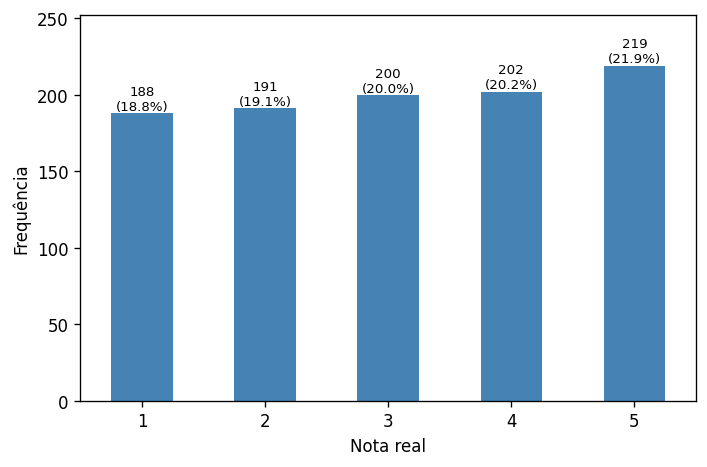

(<Figure size 720x480 with 1 Axes>,
 [<Axes: xlabel='Nota real', ylabel='Frequência'>])

In [58]:
# Distribuição da nota real
# plot_rating_distribution(df, rating_col='real_rating', color=color)
# plot_rating_distribution_by_lang(df, rating_col='real_rating', color=color)
plot_rating_distribution(df, rating_col='real_rating', color=color, mode='overall', xlabel='Nota real', show_title=False)
# plot_rating_distribution(df, rating_col='real_rating', color=color, mode='langs', title_fmt='Distribuição de Notas reais ({label})', xlabel='Nota real')

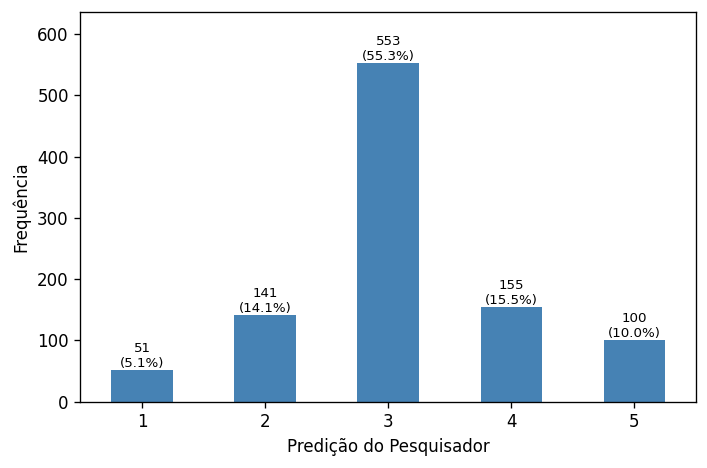

(<Figure size 720x480 with 1 Axes>,
 [<Axes: xlabel='Predição do Pesquisador', ylabel='Frequência'>])

In [59]:
# Distribuição da Classificação do Pesquisador
plot_rating_distribution(df, rating_col='manual_prediction', color=color, mode='overall', xlabel='Predição do Pesquisador', show_title=False)
# plot_rating_distribution(df, rating_col='manual_prediction', color=color, mode='langs')

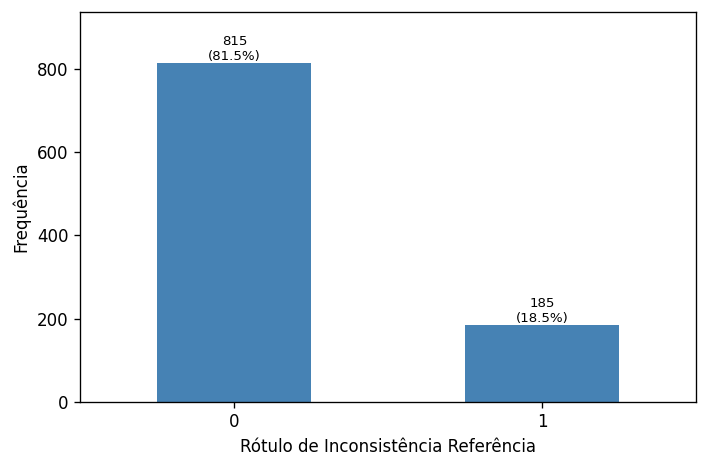

(<Figure size 720x480 with 1 Axes>,
 [<Axes: xlabel='Rótulo de Inconsistência Referência', ylabel='Frequência'>])

In [60]:
# Distribuição de RICS
plot_rating_distribution(df, rating_col='is_inconsistent_manual', color=color, mode='overall', xlabel='Rótulo de Inconsistência Referência', show_title=False)
# plot_rating_distribution(df, rating_col='is_inconsistent_manual', color=color, mode='langs')

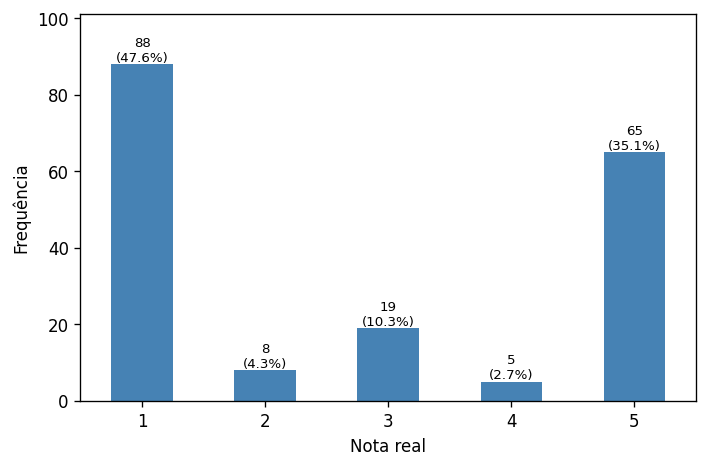

(<Figure size 720x480 with 1 Axes>,
 [<Axes: xlabel='Nota real', ylabel='Frequência'>])

In [61]:
# Distribuição de avaliações inconsistentes por nota real
plot_rating_distribution(df[df['is_inconsistent_manual']==1], rating_col='real_rating', color=color, mode='overall', xlabel='Nota real', show_title=False)

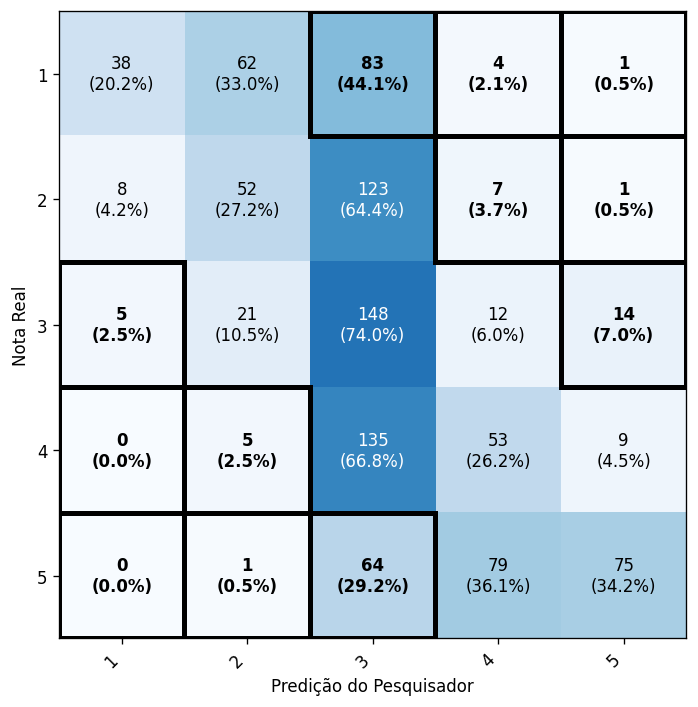

(<Figure size 960x720 with 1 Axes>,
 [<Axes: xlabel='Predição do Pesquisador', ylabel='Nota Real'>])

In [62]:
# Matriz de confusão: Nota Real por Predição do Pesquisador
plot_confusion_matrix(df, mode='overall', invert_highlight=True, show_title=False, xlabel='Predição do Pesquisador', ylabel='Nota Real' )
# plot_confusion_matrix(df, mode='langs')